In [3]:
%load_ext autoreload
%autoreload 2
# this only works on startup!
from jax import config
config.update("jax_enable_x64", True)

import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"] = '2'

from encoding_information.gpu_utils import limit_gpu_memory_growth
limit_gpu_memory_growth()

from cleanplots import *
from tqdm import tqdm
from encoding_information.information_estimation import *
from encoding_information.image_utils import *
from encoding_information.models.gaussian_process import *


from encoding_information.datasets.bsccm_utils import *
from bsccm import BSCCM
from jax import jit
import numpy as onp
import jax.numpy as np

bsccm = BSCCM('/home/hpinkard_waller/data/BSCCM/')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Opening BSCCM
Opened BSCCM


## How consistent is the condtional entropy estimator with dataset size

In [5]:
# Generate a ground truth covariance matrix for each channel, and then noiseless samples from it
from encoding_information.models.gaussian_process import StationaryGaussianProcess

num_images = 10000
num_patches = 10000
# num_images = 1000
# num_patches = 1000
edge_crop = 24

patch_size = 20
photons_per_pixel = 300

channel = 'LED119'


images = load_bsccm_images(bsccm, channel=channel, num_images=num_images, edge_crop=edge_crop, median_filter=True)
patches = extract_patches(images, num_patches, patch_size)
patches *= (photons_per_pixel / patches.mean())
noisy_patches = add_noise(patches)

# (Gaussian approx to) true conditional entropy can be gotten by computing entropy independently for each pixel
entropy = 0.5 * np.log(2 * np.pi * np.e * patches) 
py_given_x_true = np.mean(entropy)



2024-10-10 13:57:17.385980: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1125] failed to alloc 536870912 bytes on host: CUDA_ERROR_INVALID_VALUE: invalid argument
2024-10-10 13:57:17.386025: W external/xla/xla/stream_executor/device_host_allocator.h:52] could not allocate pinned host memory of size: 536870912
2024-10-10 13:57:17.388137: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1125] failed to alloc 536870912 bytes on host: CUDA_ERROR_INVALID_VALUE: invalid argument
2024-10-10 13:57:17.388166: W external/xla/xla/stream_executor/device_host_allocator.h:52] could not allocate pinned host memory of size: 536870912
2024-10-10 13:57:27.393284: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1125] failed to alloc 536870912 bytes on host: CUDA_ERROR_INVALID_VALUE: invalid argument
2024-10-10 13:57:27.393328: W external/xla/xla/stream_executor/device_host_allocator.h:52] could not allocate pinned host memory of size: 536870912
2024-10-10 13:57:27.394324: E externa

### Verify that entrpoy and mutual information estimates are consistent: they converge to the correct value given enough samples
Of course, this is on data that is sampled form a stationary gaussian process, so its only really showing that the gaussian approximation estimator can estimate gaussian entropy and MI. 


This all uses additive gaussian noise, which has an easy analytic formula for h(y | x)

In [8]:
from encoding_information.models.gaussian_process import gaussian_likelihood, nll_per_pixel_from_cov_mat
from encoding_information.models.pixel_cnn import PixelCNN
from encoding_information.models import PoissonNoiseModel

# num_samples_to_use = np.array([10, 40, 160,]).astype(int)
num_bootstraps = 100
confidence_interval = 95


# num_samples_to_use = np.array([10, 40, 160, 640, 2560, 10240]).astype(int)
num_samples_to_use = np.array([10, 20, 40, 80, 160, 320, 640, 1280, 2560]).astype(int)

noise_model = PoissonNoiseModel()

h_y_given_x_estimates_median = []
h_y_given_x_estimates_conf_int = []
for num_to_use in tqdm(num_samples_to_use):

    resample_indices = onp.random.choice(len(noisy_patches), (num_bootstraps, num_to_use), replace=True)
    noisy_patches_resampled = noisy_patches[resample_indices]
    estimates = np.array([noise_model.estimate_conditional_entropy(batch) for batch in noisy_patches_resampled])

    h_y_given_x_estimates_median.append(estimates.mean())
    h_y_given_x_estimates_conf_int.append([np.percentile(estimates, (100-confidence_interval)/2), np.percentile(estimates, 100-(100-confidence_interval)/2)])

h_y_given_x_estimates_median = np.array(h_y_given_x_estimates_median)
h_y_given_x_estimates_conf_int = np.array(h_y_given_x_estimates_conf_int)


100%|██████████| 9/9 [00:17<00:00,  1.90s/it]


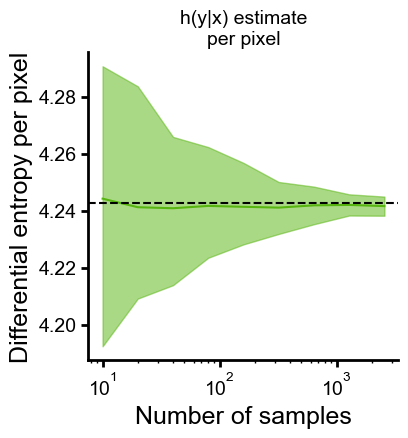

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
ax.fill_between(num_samples_to_use, h_y_given_x_estimates_conf_int[:, 0], h_y_given_x_estimates_conf_int[:, 1], alpha=0.5,
                color=get_color_cycle()[3])
ax.semilogx(num_samples_to_use, h_y_given_x_estimates_median, color=get_color_cycle()[3])
ax.set(xlabel='Number of samples', title='h(y|x) estimate\nper pixel', ylabel='Differential entropy per pixel')
# plot ground truth
ax.axhline(py_given_x_true, color='k', linestyle='--')
clear_spines(ax)


fig.savefig('/home/hpinkard_waller/figures/mi_estimation/' + 'conditional_entropy_consistency' + '.pdf', transparent=True)